# import packages

In [1]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser
from collections import defaultdict

In [2]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [10]:
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning

# deal with mcc that are classified into multiple categories (keep the main category)
tempdf = filtered_data.groupby('MCC_List')['externalParty.transactionCategory'].value_counts(ascending=False).reset_index()
tempdf = tempdf.drop_duplicates(subset=['MCC_List'], keep='first')
# remap the categories to the filtered_data
filtered_data['externalParty.transactionCategory'] = filtered_data['MCC_List'].map(tempdf.set_index('MCC_List')['externalParty.transactionCategory'])

# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]

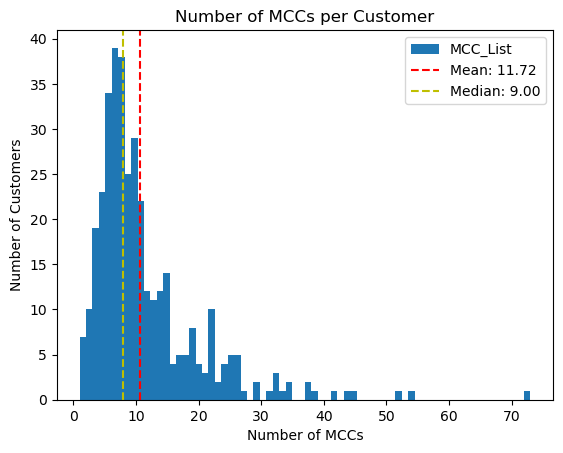

In [46]:
mccpercust = filtered_data.groupby('customerId')['MCC_List'].nunique()
# mccpercust = mccpercust.value_counts()
# mccpercust.sort_index(ascending=True, inplace=True)

mean_value = filtered_data.groupby('customerId')['MCC_List'].nunique().mean()
median_value = filtered_data.groupby('customerId')['MCC_List'].nunique().median()

# plot the number of mcc per customer
plt.figure()
mccpercust.plot(kind='hist', bins=70)
# plot the mean and median
plt.axvline(x=mean_value-1, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(x=median_value-1, color='y', linestyle='--', label=f'Median: {median_value:.2f}')
# add the mean and median values in the plot

plt.legend()
plt.xlabel('Number of MCCs')
plt.ylabel('Number of Customers')
plt.title('Number of MCCs per Customer')
# save the plot
plt.savefig('dist of mcc per cust.png')
plt.show()

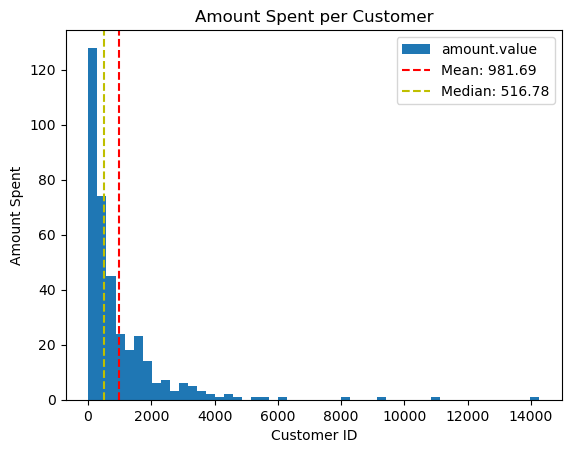

In [42]:
valuepercust = filtered_data.groupby('customerId')['amount.value'].sum()/100
valuepercust = valuepercust.sort_values(ascending=True)
# valuepercust = valuepercust[valuepercust < 1000]

# plot the amount spent per customer
plt.figure()
valuepercust.plot(kind='hist', bins=50)

mean_value = filtered_data.groupby('customerId')['amount.value'].sum().mean()/100
median_value = filtered_data.groupby('customerId')['amount.value'].sum().median()/100

plt.axvline(x=mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(x=median_value, color='y', linestyle='--', label=f'Median: {median_value:.2f}')

plt.legend()
plt.xlabel('Customer ID')
plt.ylabel('Amount Spent')
plt.title('Amount Spent per Customer')
plt.savefig('amount spent per cust.png')
plt.show()

In [3]:
#filtered_data = pd.read_csv('/Users/ognyansimeonov/Desktop/MAC-MIGS/PhD/Code/Data/Transactions_Data_with_COICOP.csv')
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning

# deal with mcc that are classified into multiple categories (keep the main category)
tempdf = filtered_data.groupby('MCC_List')['externalParty.transactionCategory'].value_counts(ascending=False).reset_index()
tempdf = tempdf.drop_duplicates(subset=['MCC_List'], keep='first')
# remap the categories to the filtered_data
filtered_data['externalParty.transactionCategory'] = filtered_data['MCC_List'].map(tempdf.set_index('MCC_List')['externalParty.transactionCategory'])

# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]

# drop the customers with less than 5 unique MCCs, to better represent the customer's spending habits
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data.groupby('customerId')['MCC_List'].nunique()>4)]

# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

# build a network

In [4]:
# calculate the proportion of each MCC for each customer
proportion_matrix = filtered_data.groupby('customerId')['MCC_List'].value_counts(normalize=True).unstack().fillna(0)
proportion_matrix

MCC_List                              Advertising Services  Aer Lingus  \
customerId                                                               
01968de9-41cb-4509-b0a6-6bdc02700150                   0.0         0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                   0.0         0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                   0.0         0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                   0.0         0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                   0.0         0.0   
...                                                    ...         ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                   0.0         0.0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                   0.0         0.0   
feb37e88-b280-40b8-b887-30961016417c                   0.0         0.0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                   0.0         0.0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                   0.0         0.0   

MCC_List                              Airlines and Air Carriers  \
customerId                                                        
01968de9-41cb-4509-b0a6-6bdc02700150                   0.000000   
01b34ce5-ce43-4c2d-a73d-5294376bd399                   0.000000   
01b4698f-32be-4bc0-9b69-b3024ac18004                   0.000000   
01ef943c-d661-48b0-9c0b-bb456a7d998d                   0.000000   
03025a2b-9179-4da9-8dff-af4a3179ce7f                   0.000000   
...                                                         ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                   0.000000   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                   0.009119   
feb37e88-b280-40b8-b887-30961016417c                   0.000000   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                   0.000000   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                   0.000000   

MCC_List                              Airports, Flying Fields, and Airport Terminals   \
customerId                                                                              
01968de9-41cb-4509-b0a6-6bdc02700150                                              0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                                              0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                                              0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                                              0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                                              0.0   
...                                                                               ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                                              0.0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                                              0.0   
feb37e88-b280-40b8-b887-30961016417c                                              0.0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                                              0.0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                                              0.0   

MCC_List                              Amusement Parks, Circuses, Carnivals, and Fortune Tellers   \
customerId                                                                                         
01968de9-41cb-4509-b0a6-6bdc02700150                                           0.000000            
01b34ce5-ce43-4c2d-a73d-5294376bd399                                           0.000000            
01b4698f-32be-4bc0-9b69-b3024ac18004                                           0.000000            
01ef943c-d661-48b0-9c0b-bb456a7d998d                                           0.000000            
03025a2b-9179-4da9-8dff-af4a3179ce7f                                           0.000000            
...                                                                                 ...            
fcfd36e4-da5e-42d1-8769-8213878b08fe                                           0.000000            
fd654d64-f795-401d-a5fe-76cfa2cfa01a                                           0.000000            
feb37e8

In [5]:
# calculate the average proportion
average_proportion = proportion_matrix.mean()
average_proportion

MCC_List
Advertising Services                                          0.004572
Aer Lingus                                                    0.000058
Airlines and Air Carriers                                     0.000163
Airports, Flying Fields, and Airport Terminals                0.000007
Amusement Parks, Circuses, Carnivals, and Fortune Tellers     0.000359
                                                                ...   
Watch, Clock, and Jewelry Repair Shops                        0.000015
Wholesale Club with or without membership fee                 0.000188
Wig & Toupee Shops                                            0.000277
Women's Accessory and Specialty Stores                        0.000008
Women's Ready-to-Wear Stores                                  0.000596
Length: 198, dtype: float64

In [6]:
# create a connection matrix between customers and MCCs if proportion of customer's transactions is greater than the average proportion
connection_matrix = proportion_matrix > average_proportion
connection_matrix = connection_matrix.astype(int)
connection_matrix

MCC_List                              Advertising Services  Aer Lingus  \
customerId                                                               
01968de9-41cb-4509-b0a6-6bdc02700150                     0           0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                     0           0   
01b4698f-32be-4bc0-9b69-b3024ac18004                     0           0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                     0           0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                     0           0   
...                                                    ...         ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                     0           0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                     0           0   
feb37e88-b280-40b8-b887-30961016417c                     0           0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                     0           0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                     0           0   

MCC_List                              Airlines and Air Carriers  \
customerId                                                        
01968de9-41cb-4509-b0a6-6bdc02700150                          0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                          0   
01b4698f-32be-4bc0-9b69-b3024ac18004                          0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                          0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                          0   
...                                                         ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                          0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                          1   
feb37e88-b280-40b8-b887-30961016417c                          0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                          0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                          0   

MCC_List                              Airports, Flying Fields, and Airport Terminals   \
customerId                                                                              
01968de9-41cb-4509-b0a6-6bdc02700150                                                0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                                                0   
01b4698f-32be-4bc0-9b69-b3024ac18004                                                0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                                                0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                                                0   
...                                                                               ...   
fcfd36e4-da5e-42d1-8769-8213878b08fe                                                0   
fd654d64-f795-401d-a5fe-76cfa2cfa01a                                                0   
feb37e88-b280-40b8-b887-30961016417c                                                0   
ff6ef7e8-4b43-44f7-a1ef-7d35407c2219                                                0   
ffcf3506-a7d8-48a0-ba54-d4d54d15ee78                                                0   

MCC_List                              Amusement Parks, Circuses, Carnivals, and Fortune Tellers   \
customerId                                                                                         
01968de9-41cb-4509-b0a6-6bdc02700150                                                  0            
01b34ce5-ce43-4c2d-a73d-5294376bd399                                                  0            
01b4698f-32be-4bc0-9b69-b3024ac18004                                                  0            
01ef943c-d661-48b0-9c0b-bb456a7d998d                                                  0            
03025a2b-9179-4da9-8dff-af4a3179ce7f                                                  0            
...                                                                                 ...            
fcfd36e4-da5e-42d1-8769-8213878b08fe                                                  0            
fd654d64-f795-401d-a5fe-76cfa2cfa01a                                                  0            
feb37e8

In [9]:
# stack the connection matrix to create a list of tuples
connection_list = connection_matrix.stack().reset_index()
connection_list.columns = ['customerId', 'MCC_List', 'connection']
connection_list = connection_list[connection_list['connection'] == 1]
connection_list.reset_index(drop=True, inplace=True)
connection_list

customerId  \
0     01968de9-41cb-4509-b0a6-6bdc02700150   
1     01968de9-41cb-4509-b0a6-6bdc02700150   
2     01968de9-41cb-4509-b0a6-6bdc02700150   
3     01968de9-41cb-4509-b0a6-6bdc02700150   
4     01968de9-41cb-4509-b0a6-6bdc02700150   
...                                    ...   
3271  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
3272  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
3273  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
3274  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
3275  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   

                                         MCC_List  connection  
0                                        Bakeries           1  
1                         Beauty and Barber Shops           1  
2         Bus Lines, includes Charters/Tour Buses           1  
3            Candy, Nut, and Confectionary Stores           1  
4                        Computer Software Stores           1  
...                                           ...         ...  
3271                                  Shoe Stores           1  
3272             Sporting and Recreational Camps            1  
3273  Stationery, Office and School Supply Stores           1  
3274             Tourist Attractions and Exhibits           1  
3275                  Video Amusement Game Supply           1  

[3276 rows x 3 columns]

In [52]:
customer_mcc_dict = {}
for _, row in connection_list.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]
customer_mcc_dict

{'01968de9-41cb-4509-b0a6-6bdc02700150': ['Bakeries',
  'Beauty and Barber Shops',
  'Bus Lines, includes Charters/Tour Buses',
  'Candy, Nut, and Confectionary Stores',
  'Computer Software Stores',
  'Continuity/Subscription Merchants',
  'Direct Marketing/Direct Marketers--Not Elsewhere Classified',
  'Discount Store',
  'Drinking Places (Alcoholic Beverages) - Bars, Taverns, Nightclubs, Cocktail Lounges, and Discotheques',
  'Duty Free Stores',
  'Eating Places and Restaurants',
  'Electrical Parts and Equipment (Business to Business MCC)\xa0',
  'Florists',
  'Government Services - Not Elsewhere Classified\xa0',
  'Grocery Stores and Supermarkets',
  'Lodging - Hotels, Motels, and Resorts',
  'Miscellaneous & Specialty Retail Stores',
  'Miscellaneous Apparel and Accessory Stores',
  'Miscellaneous Personal Services - Not Elsewhere Classified',
  'Package Stores--Beer, Wine, and Liquor',
  'Postal Services',
  'Ryan Air - RYANAIR',
  'Stationery, Office and School Supply Stores',


In [53]:
# Create the CustomerID array
CustomerID = list(customer_mcc_dict.keys())

# Create the MCC array by zipping the two lists together
MCC = [customer_mcc_dict[customer_id] for customer_id in CustomerID]

# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))
print(len(CustomerID))

333


In [54]:
# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))

if are_all_unique:
    print("All values in CustomerID are unique.")
else:
    print("There are duplicate values in CustomerID.")

All values in CustomerID are unique.


In [57]:
#Check for a random customer/MCC in Excel to make sure it is correct
i_doc = 332
print(CustomerID[i_doc])
print(MCC[i_doc][:10])

ffcf3506-a7d8-48a0-ba54-d4d54d15ee78
['Amusement Parks, Circuses, Carnivals, and Fortune Tellers\xa0', 'Artist Supply and Craft Stores', 'Bakeries', 'Beauty and Barber Shops', 'Book Stores', 'Caterers - Prepare & Delivery', 'Charitable and Social Service Organizations', 'Commercial Sports, Professional Sports Clubs, Athletic Fields, and Sports Promoters', 'Dance Halls, Studios & Schools', 'Drug Stores and Pharmacies']


# Create Model and Plot

In [58]:
## Create the sbmtm model
model = sbmtm()

## we have to create the customer-MCC network from the data
model.make_graph(MCC,documents=CustomerID,counts=False, count_log=False)

model.g

<Graph object, undirected, with 531 vertices and 3276 edges, 2 internal vertex properties, at 0x7f6aaf2b10a0>

In [60]:
SEED = 41
gt.seed_rng(SEED) ## seed for graph-tool's random number generator --> same results

#fit the model
model.fit(n_init=100, verbose=False)

print('The lowest entropy was {}, and the state has {} blocks at level 0'.format(model.state.entropy(),model.state.get_levels()[0].get_nonempty_B()))
with open('./Results/uw_minimized_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model,f)

10596.59527542674
10582.6699241595
10574.75959961993
10585.892348718911
10586.034731404094
10575.20879603608
10583.98798159999
10586.360784903614
10575.645960587619
10573.850890665006
10652.294277646763
10652.294277646763
10573.834049787245
10573.605297520151
10585.749001657778
10581.044815787549
10573.850900916148
10573.897169152287
10573.708306637742
10593.898777857288
10584.220501335865
10573.708306637745
10574.753640985318
10595.887587017605
10584.381622762616
10652.294277646763
10574.356870099858
10652.294277646763
10573.904395704298
10586.463644850199
10574.674081488403
10574.518826458825
10577.420061681843
10598.962431584947
10573.605297520155
10575.231242614052
10604.291277067641
10652.294277646763
10574.327476616665
10578.711052776
10576.855710274067
10575.55093564644
10582.74866974113
10574.755409011581
10575.062891258403
10578.947497033576
10652.294277646763
10577.906007021276
10578.215688732362
10580.636009349775
10573.83560202671
10608.642044838489
10598.365761334995
10589

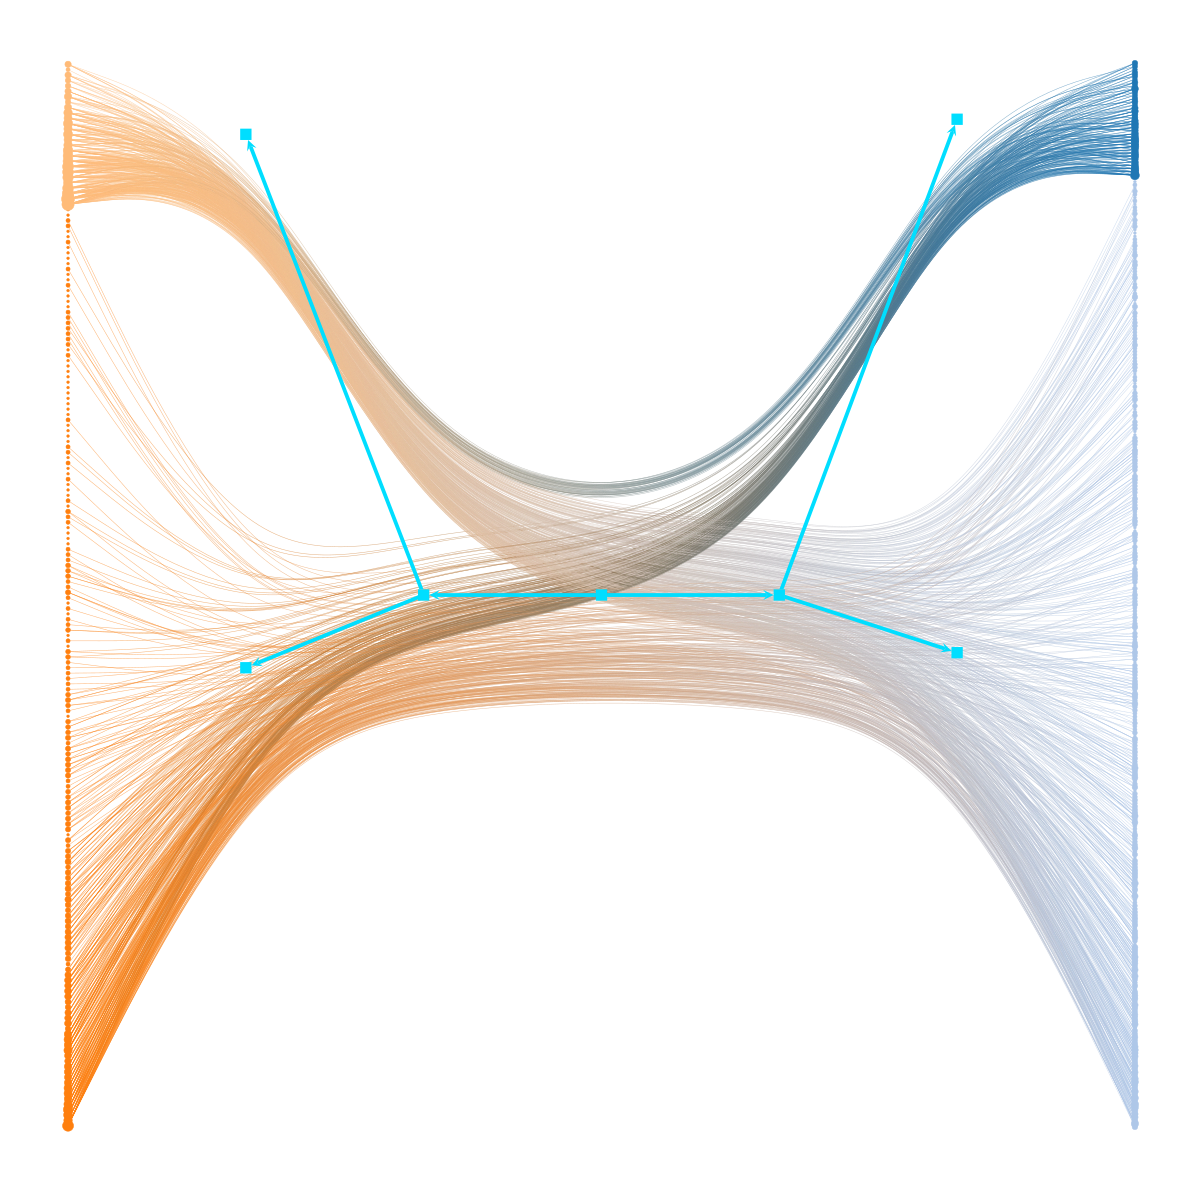

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6aaf2b10a0, at 0x7f6aad018710>,
 <GraphView object, directed, with 538 vertices and 537 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f6aad0191f0, at 0x7f6aad01adb0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f6aad0191f0, at 0x7f6aad10c650>, False), at 0x7f6aad0191f0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6aad0191f0, at 0x7f6aacac3200>)

In [61]:
#Plot
model.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

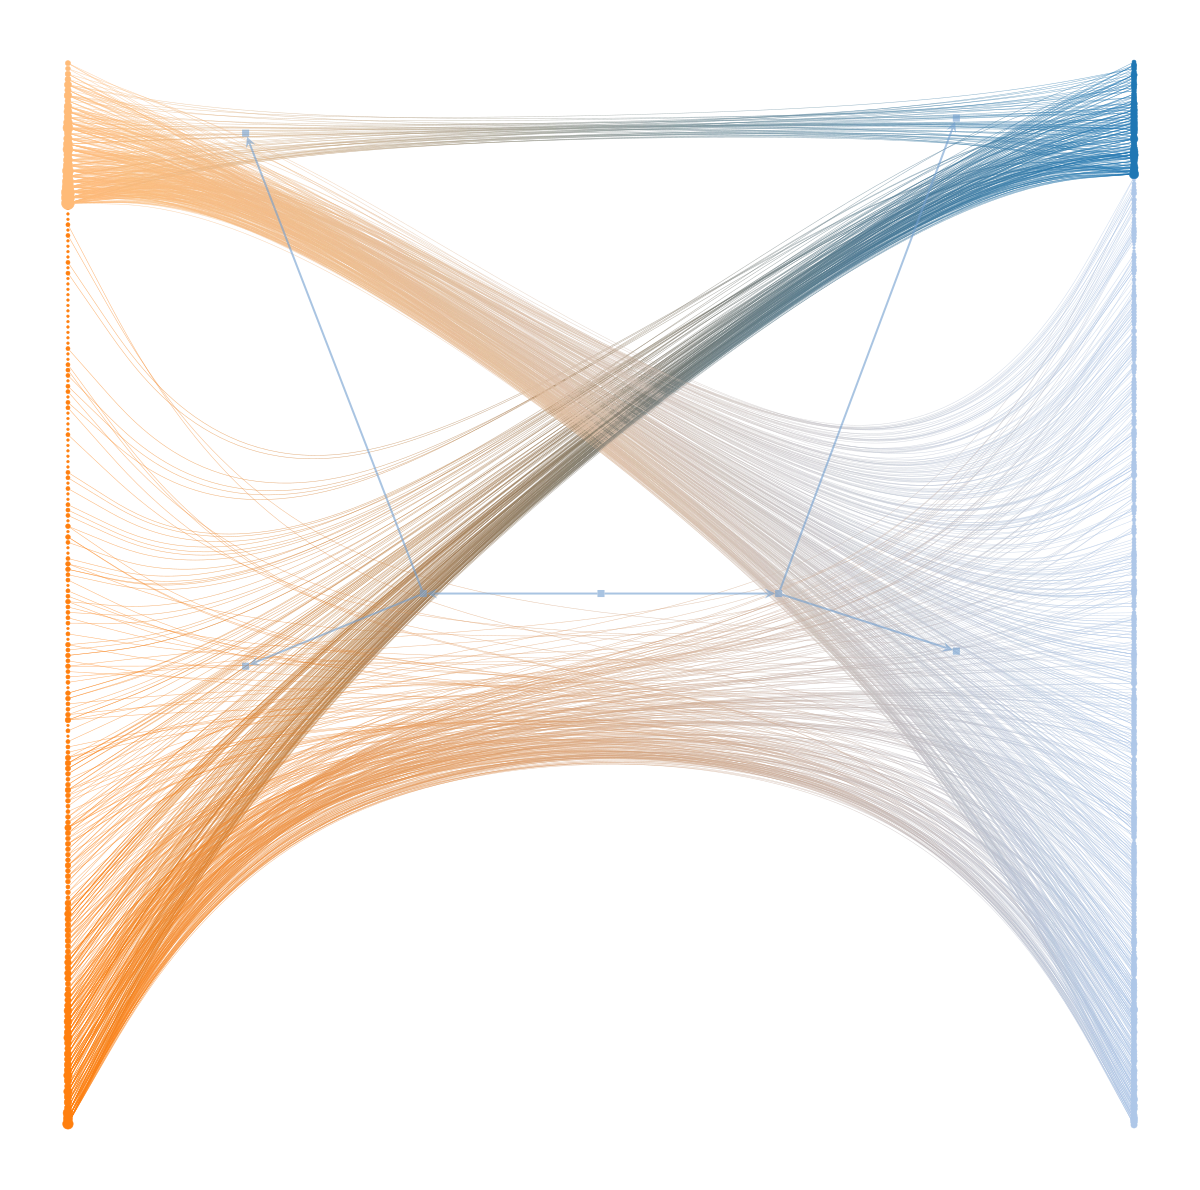

In [62]:
model.plot()

In [63]:
with open("./Results/uw_minimized_model_seed_{}.pkl".format(SEED), "rb") as f:
        model_100 = pickle.load(f)
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 4 blocks at level 0, 2 at level 1, and its entropy is entropy: 10573.61


In [69]:
starting_entropy=model_100.state.entropy()
entropy_gain_multiflip=[model_100.state.multiflip_mcmc_sweep(beta=np.inf, niter=50)[0] for i in range(1000)]

In [70]:
model_100.state.entropy()

10573.605297520155

In [71]:
entropy_diff = np.cumsum(np.array(entropy_gain_multiflip))
entropy_diff_positive = -entropy_diff
# entropy_exp_10 = entropy_diff_positive/(np.log(2)+np.log(5))
# entropy_likelihood = np.power(10,entropy_exp_10)

In [72]:
with open('./Results/uw_multiflip_mcmc_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model_100,f)

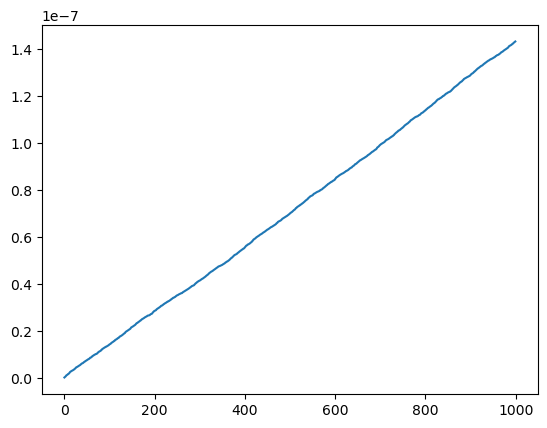

In [73]:
plt.plot(entropy_diff_positive)

In [74]:
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 4 blocks at level 0, 2 at level 1, and its entropy is entropy: 10573.61


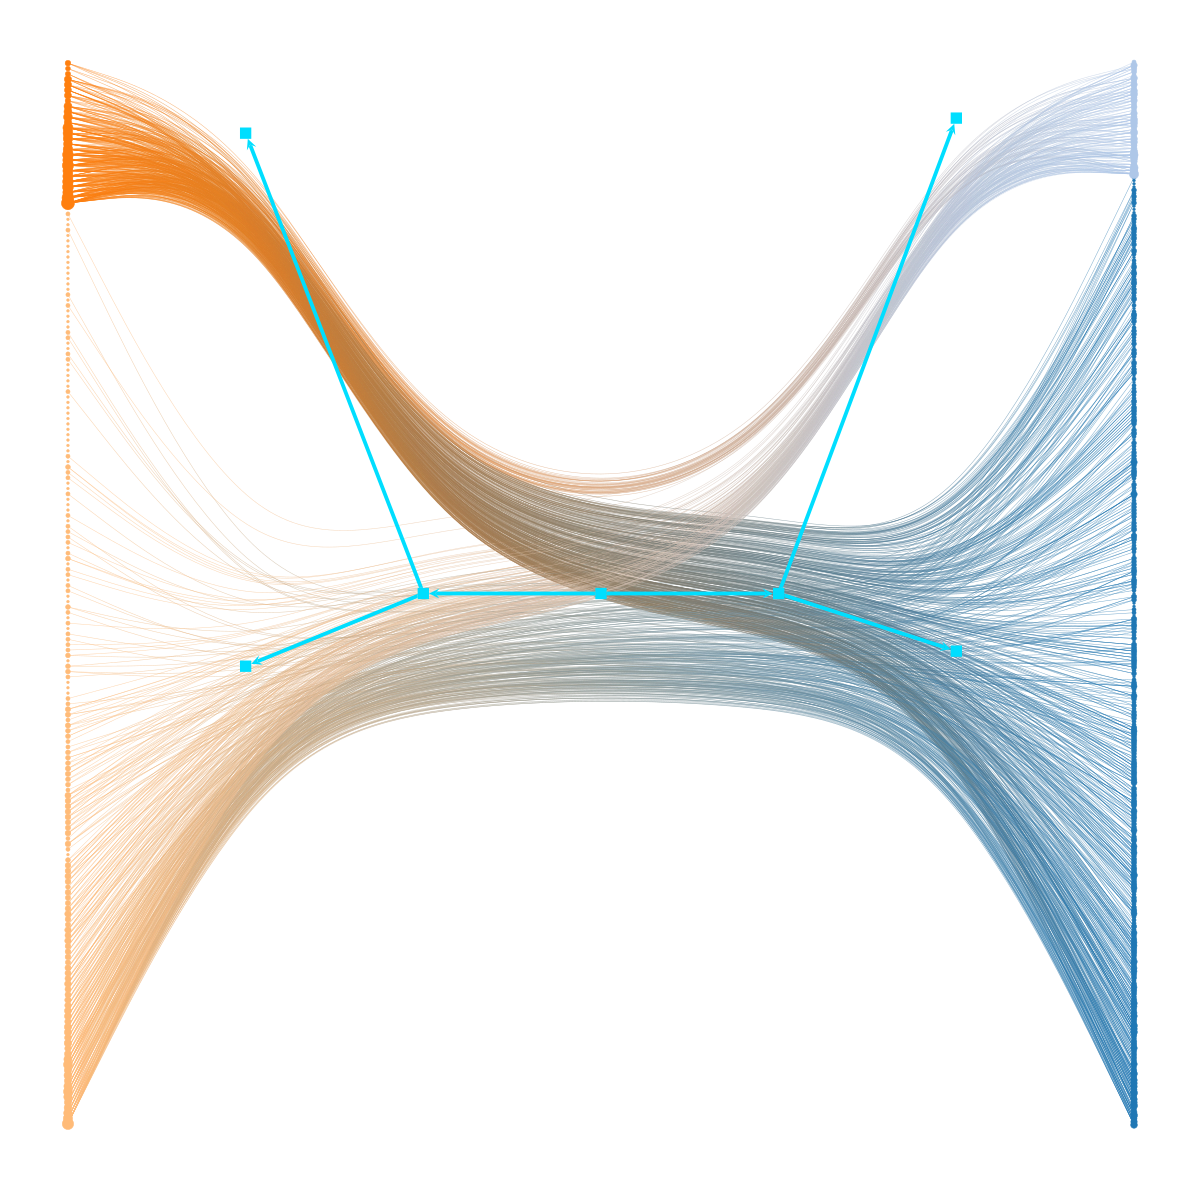

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6aad01a7b0, at 0x7f6aad10c320>,
 <GraphView object, directed, with 538 vertices and 537 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f6aac8e17c0, at 0x7f6aac8e1760>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f6aac8e17c0, at 0x7f6aae0a0590>, False), at 0x7f6aac8e17c0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6aac8e17c0, at 0x7f6aae2783b0>)

In [75]:
#Plot
model_100.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [76]:
# get the number of documents in each topic(cluster) at level 1
# model.clusters(l=1)
# print the number of documents in each topic(cluster) at level 1
x = 0
for i in range(len(model_100.clusters(l=0))):
    x += len(model_100.clusters(l=0,n=400)[i])
    print('The number of documents in topic {} is {}'.format(i+1,len(model_100.clusters(l=0,n=400)[i])))
print('The total number of documents is {}'.format(x))

The number of documents in topic 1 is 36
The number of documents in topic 2 is 297
The total number of documents is 333


<Axes: >

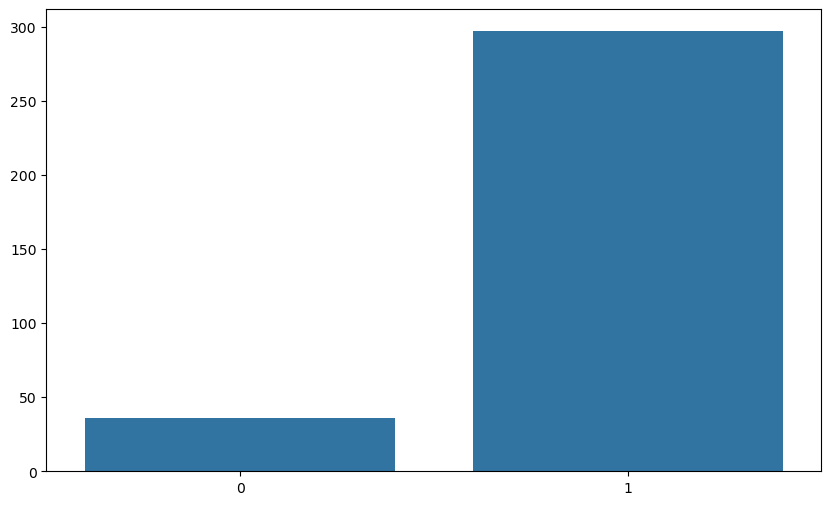

In [77]:
# plot the number of documents in each topic(cluster) at level 1, labeled by the topic(cluster) number
plt.figure(figsize=(10,6))
sns.barplot([len(model_100.clusters(l=0,n=400)[i]) for i in range(len(model_100.clusters(l=0)))])

# Model Analysis

In [78]:
Customer_clusters = model_100.clusters(l=0,n=1000).items()
Customer_clusters = [[id for id, p in cluster] for i, cluster in Customer_clusters]
Customer_clusters

[['3253926e-9c0d-4fd9-8248-eb7c2f457b99',
  '75152c18-f4aa-42e2-ad90-ad74beddd74c',
  '2f786a32-88b8-4aa3-9081-019f79125a49',
  'b1f49bc3-ec64-4182-9ab8-3aeaaaf72785',
  '40145ab5-241c-47c5-bb6a-3a05374b28a9',
  '2aa2a980-470d-470a-8379-ec51e5036ee4',
  '923e9cd3-7c8e-4f9d-8e21-d66438382db9',
  '1a20b9da-7ae4-4dd1-a27e-b6883585dec0',
  'b15a3e38-2f9d-434d-9814-094ca59a18c7',
  'e1090e22-632f-45e4-a480-b9206b3a573d',
  'b2a6900a-e6e6-4875-bf1b-b41c13c0dfc8',
  '03025a2b-9179-4da9-8dff-af4a3179ce7f',
  '248d3016-b0ad-41a3-b287-8477efdc36c4',
  'b3ec512b-ffff-4d83-baa3-ecd8374a398b',
  'f62c7154-a4a8-4085-ac99-aac7ae6ba660',
  'b2b7ac22-8e95-460f-a6e7-a94a3b3b01df',
  'ffcf3506-a7d8-48a0-ba54-d4d54d15ee78',
  '9b360110-de0a-4c9f-a913-0186e642f1f2',
  '01968de9-41cb-4509-b0a6-6bdc02700150',
  'ce3d4f74-f5ea-4d78-8ba8-ceca45235edb',
  'fcfd36e4-da5e-42d1-8769-8213878b08fe',
  'a926714a-3061-4fe5-a890-c96c302b4dff',
  '7c86d4bd-ef5a-49af-98b4-fca3ea6c809b',
  'd7ee236c-7eeb-4020-bd04-613093a

In [79]:
l0 = model_100.clusters(l=0,n=1000).items()
l0 = [(id, i) for i, cluster in l0 for id, p in cluster]
df_clusters = pd.DataFrame(l0, columns=['node', 'level_0'])
df_clusters

node  level_0
0    3253926e-9c0d-4fd9-8248-eb7c2f457b99        0
1    75152c18-f4aa-42e2-ad90-ad74beddd74c        0
2    2f786a32-88b8-4aa3-9081-019f79125a49        0
3    b1f49bc3-ec64-4182-9ab8-3aeaaaf72785        0
4    40145ab5-241c-47c5-bb6a-3a05374b28a9        0
..                                    ...      ...
328  fb76a679-f1f5-44d0-81fd-69059c63167d        1
329  fa087e58-6544-4440-b110-868e0a57219a        1
330  f9bcc003-9651-4728-bf26-c43f8fde8915        1
331  f85271bb-aa0a-4b73-89d3-a2bd2e84e578        1
332  f6f0dbd8-6e8d-4ec3-8b95-44f8e49317cb        1

[333 rows x 2 columns]

In [80]:
l0 = model_100.topics(l=0,n=1000).items()
l0 = [(id, i, p) for i, cluster in l0 for id, p in cluster]
df_topics = pd.DataFrame(l0, columns=['node', 'level_0', 'p'])
df_topics

node  level_0         p
0    Drinking Places (Alcoholic Beverages) - Bars, ...        0  0.050971
1                    Miscellaneous General Merchandise        0  0.038835
2             Gift, Card, Novelty, and Souvenir Stores        0  0.030340
3                             Parking Lots and Garages        0  0.029126
4          Charitable and Social Service Organizations        0  0.026699
..                                                 ...      ...       ...
193  Quasi Cash - Financial Institution - Merchandi...        1  0.012285
194                            Digital Goods – Games          1  0.011057
195                               Advertising Services        1  0.008600
196   Telecommunication Equipment and Telephone Sales         1  0.006143
197              Video Game Arcades and Establishments        1  0.006143

[198 rows x 3 columns]

In [81]:
df_topics['node'].nunique()

198

## IMD and Age by clusters

In [82]:
df_imd = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='IMD_Rank')
df_imd.drop_duplicates(subset='CustomerId', inplace=True)
df_customer = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='ekko_customer_info')
print('Before dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_imd.dropna(inplace=True)
df_imd.reset_index(drop=True, inplace=True)
df_customer.dropna(inplace=True)
df_customer.reset_index(drop=True, inplace=True)
print('After dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_customer.head()

Before dropping NaN values:
(873, 28)
(12986, 6)
After dropping NaN values:
(873, 28)
(11931, 6)


Sender_customer_Id address.postcode address.townOrCity  \
0  eecbba00-41c0-4111-ae83-286a302fed0c          NW1 9DR             London   
1  dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad          SM2 6DU             Sutton   
2  bb10d50e-5e6a-43c2-bd6d-323b7d9c731f          SW1W0NY             London   
3  5c0a9926-a3b5-4441-945b-c1f619ed339a           SM25HT             Sutton   
4  12ea2e69-cea2-4e47-9d21-55402dd47811          SW1W0NY             London   

                  createdAt               dateOfBirth     nationality  
0  2021-11-04T12:46:07.257Z  1995-05-21T00:00:00.000Z  United Kingdom  
1  2021-12-09T18:04:46.294Z  1981-10-30T00:00:00.000Z  United Kingdom  
2  2021-12-15T11:41:54.937Z  1991-04-11T00:00:00.000Z  United Kingdom  
3  2021-12-15T13:33:27.821Z  1986-05-22T00:00:00.000Z  United Kingdom  
4  2021-12-15T14:31:52.354Z  1991-04-11T00:00:00.000Z  United Kingdom

In [83]:
# calculate the age of the customers
df_customer['age'] = df_customer.apply(lambda x: 2024 - parser.parse(x['dateOfBirth']).year, axis=1)
# df_customer.head()

In [84]:
df_imd['age'] = df_imd['CustomerId'].map(df_customer.set_index('Sender_customer_Id')['age'])
# df_imd['level_0'] = df_imd['CustomerId'].map(df_clusters.set_index('node')['level_0'])
df_imd.head()

CustomerId  Index_of_Multiple_Deprivation_Decile  \
0  db9b8ecb-173d-43fb-bff6-b7f7b54b603b                                     3   
1  60614561-6838-4200-a37c-978cdffad096                                     2   
2  886926ad-2f76-4746-a7fc-ca1473c848a3                                     9   
3  55929e08-6995-4766-ad89-402bb47358f8                                     4   
4  ae54b0a2-7ad3-432c-ae1b-040e9365f8ee                                     7   

  Postcode_Status  LSOA_code                   LSOA_Name  \
0            Live  E01010959   Calderdale 020D E01010959   
1            Live  E01011043     Kirklees 031B E01011043   
2            Live  E01004694  Westminster 016C E01004694   
3            Live  E01027498     Tynedale 005B E01027498   
4            Live  E01001642    Greenwich 038C E01001642   

   Index_of_Multiple_Deprivation_Rank  Income_Rank  Income_Decile  \
0                                8106         7040              3   
1                                5947         6529              2   
2                               26491        31488             10   
3                               12152         8097              3   
4                               22742        26579              9   

   Income_Score  Employment_Rank  ...  \
0         0.194             5093  ...   
1         0.202             6750  ...   
2         0.026            32231  ...   
3         0.179             9178  ...   
4         0.048            30198  ...   

   Barriers_to_Housing_and_Services_Decile  Living_Environment_Rank  \
0                                       10                     9666   
1                                        5                     1975   
2                                        3                     5526   
3                                        8                    32328   
4                                        6                     6012   

   Living_Environment_Decile  IDACI_Rank  IDACI_Decile  IDACI_Score  \
0                          3        6327             2        0.260   
1                          1        9700             3        0.206   
2                          2       32013            10        0.019   
3                         10        9016             3        0.216   
4                          2       21946             7        0.082   

   IDAOPI_Rank  IDAOPI_Decile  IDAOPI_Score   age  
0        12134              4         0.172  29.0  
1         3799              2         0.324  26.0  
2        19729              7         0.102  27.0  
3         7387              3         0.241  28.0  
4        25719              8         0.067  56.0  

[5 rows x 29 columns]

In [85]:
def calculate_average_age_and_IMD(cluster_index, df_imd, clusters):
    # Get the customer IDs in the specified cluster
    customer_cluster = clusters[cluster_index]

    # Filter the DataFrame to include only customers in the current cluster
    cluster_data = df_imd[df_imd['CustomerId'].isin(customer_cluster)]
    
    # Calculate the average age and IMD_Rank for the cluster
    average_age = cluster_data['age'].mean()
    average_IMD = cluster_data['Index_of_Multiple_Deprivation_Decile'].mean()
    
    return average_age, average_IMD
customer_data_cleaned = df_imd
# Example usage:
for index in range(len(Customer_clusters)):
    cluster_index = index  # Replace this with the desired cluster index
    avg_age, avg_IMD = calculate_average_age_and_IMD(cluster_index, customer_data_cleaned, Customer_clusters)
    print(f"For cluster {cluster_index + 1}, the average age is {avg_age:.2f} and the average IMD_Rank is {avg_IMD:.2f}")


For cluster 1, the average age is 40.79 and the average IMD_Rank is 6.73
For cluster 2, the average age is 30.40 and the average IMD_Rank is 4.11


## Heatmaps of Purchases by Cluster

In [86]:
def heatmaps(df_clusters, df, yvalues=['MCC_List'], xvalues=['levels'], topn=False, relative=False, value='frequency', level_detail=False, max_label_len=False):
    '''
    df_clusters: DataFrame, the DataFrame with the cluster information
    df: DataFrame, the DataFrame with the transactions data
    yvalues: list, hierarchical levels to be used as y-axis values (categories)
    xvalues: list, hierarchical levels to be used as x-axis values (levels)
    topn: int, the number of top categories to be shown in the heatmap, valid only if yvalues has one level
    relative: bool, if True, the heatmap will show the relative frequency of the categories
    '''
    if len(yvalues) == 2:
        df['y'] = df[yvalues[0]] + '_' + df[yvalues[1]]
        annot = False
        ytick = False
    else:
        df['y'] = df[yvalues[0]]
        annot = True
        ytick = True
    # population average of the transactions frequency/amount for calculating the relative frequency
    if value == 'frequency':
        df_avg = df['y'].value_counts(normalize=True).reset_index().set_index('y')
        df['count'] = 1
    elif value == 'amount':
        df_avg = (df.groupby('y')['amount.value'].sum()/df['amount.value'].sum()).rename('proportion').reset_index().set_index('y')
        df['count'] = df['amount.value']

    # Get the normalized MCC transaction counts for each cluster
    cluster_counts = []
    for cluster in df_clusters[xvalues[-1]].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        custid = df_clusters[df_clusters[xvalues[-1]] == cluster]['node'].values
        filtered_df = df[df['customerId'].isin(custid)]
        if relative:
            # Calculate the normalized counts for each MCC category
            # counts = np.log(filtered_df[yvalues[-1]].value_counts(normalize=True) / df_avg['proportion']).rename(cluster)
            counts = np.log((filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()) / df_avg['proportion']).rename(cluster)
        else:
            counts = (filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()).rename(cluster)
        cluster_counts.append(counts)

    # Combine the normalized counts into a single DataFrame
    df_data = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # limit the length of the index
    if max_label_len:
        df_data.index = df_data.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
        df_avg.index = df_avg.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
    limit = np.max([np.abs(df_data.min().min()), df_data.max().max()])

    # shows only the top mcc if topn is given
    if topn:
        # Get the top 10 categories with the highest average transaction percentages
        topn_index = df_avg.nlargest(topn, df_avg.keys()[0]).index
        # Filter the DataFrame to keep only the top categories
        df_data = df_data.loc[topn_index]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    if relative:
        sns.heatmap(df_data, cmap='PiYG', fmt='.2f', annot=annot, linewidths=.5, vmin=-limit, vmax=limit, yticklabels=ytick, xticklabels=level_detail)
    else:
        sns.heatmap(df_data, cmap='Reds', fmt='.2%', annot=annot, linewidths=.5, yticklabels=ytick, xticklabels=level_detail)
    if len(yvalues) == 2:
        for category, y in df.groupby(yvalues[0])['y'].nunique().sort_index().cumsum().items():
            plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
            plt.text(-1, y-0.5, category, ha='center', va='center', fontsize=8)
    if len(xvalues) == 2:
        y = len(df_data.index)
        for level, x in df_clusters.groupby(xvalues[0])[xvalues[1]].nunique().sort_index().cumsum().items():
            plt.axvline(x=x, color='gray', lw=0.5, linestyle='--')
            if level_detail == False:
                plt.text(x-0.5, y*1.01, level, ha='center', va='center', fontsize=8)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

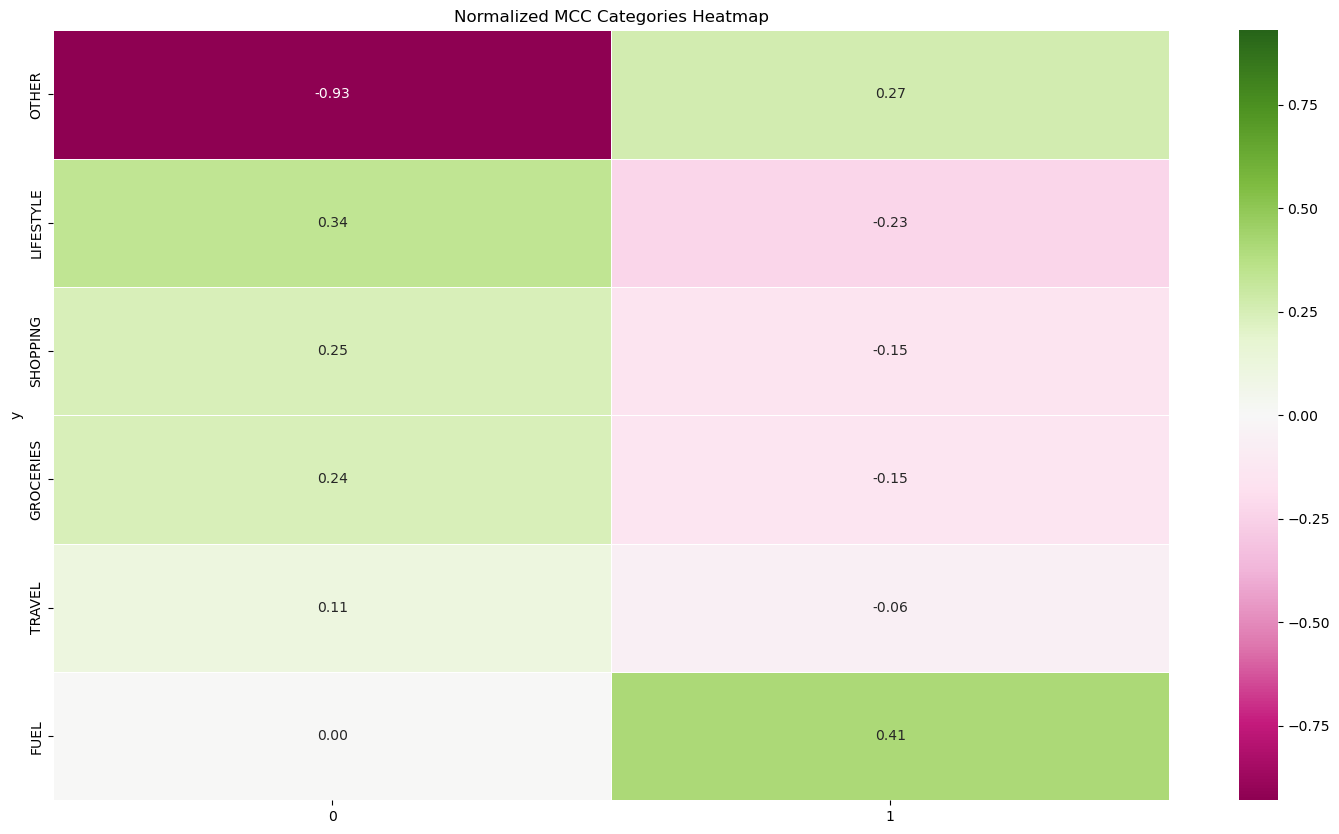

In [87]:
heatmaps(df_clusters, filtered_data, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], topn=20, relative=True, value='amount', level_detail=True)

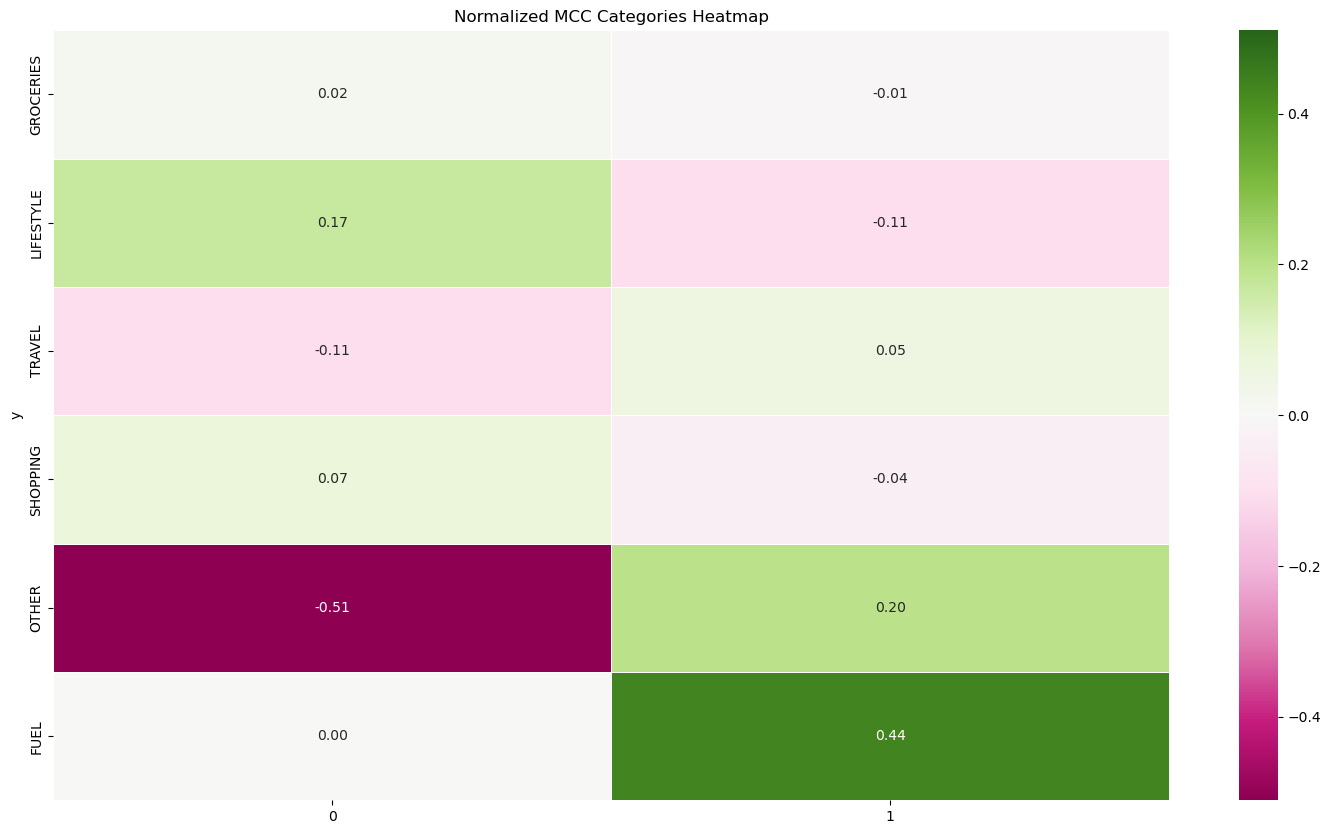

In [88]:
heatmaps(df_clusters, filtered_data, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], topn=20, relative=True, value='frequency', level_detail=True)

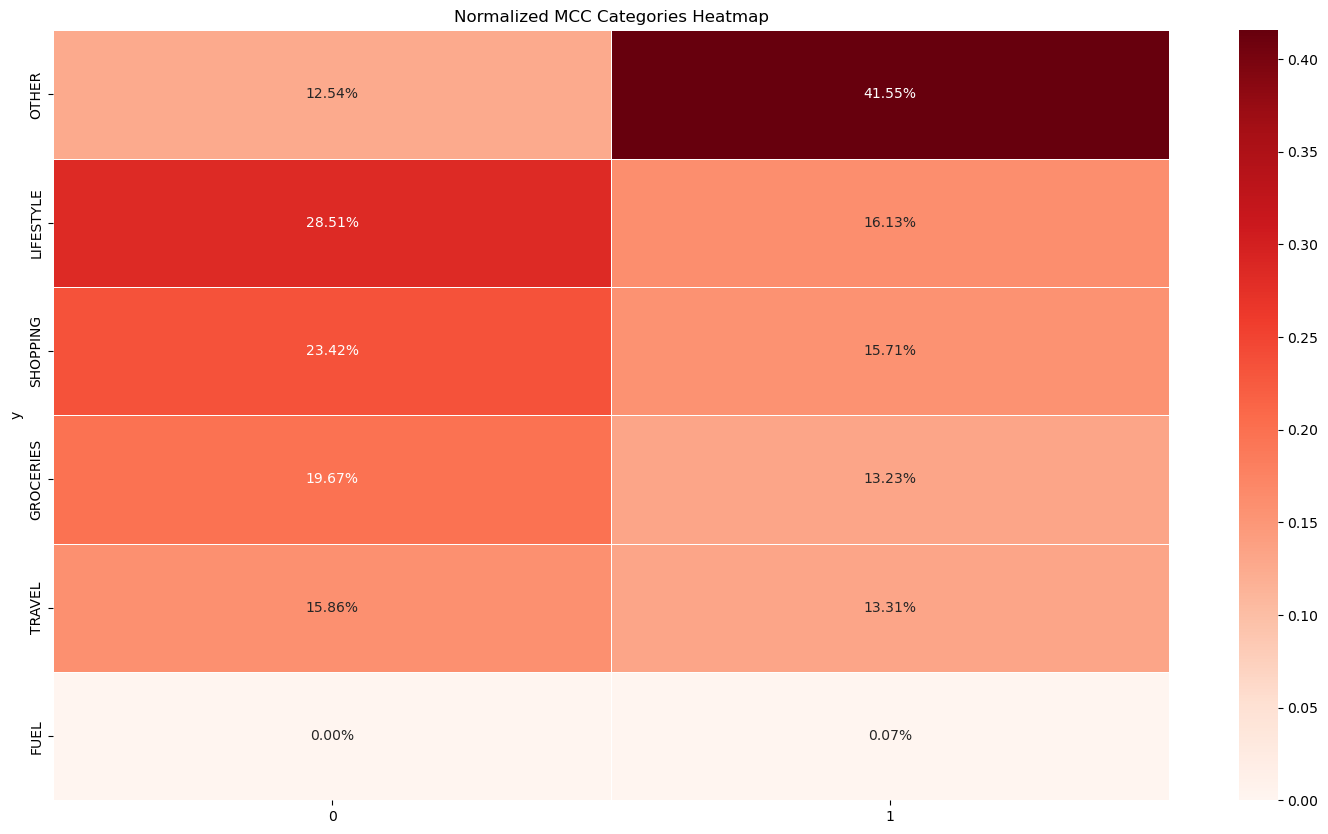

In [89]:
heatmaps(df_clusters, filtered_data, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], topn=20, relative=False, value='amount', level_detail=True)

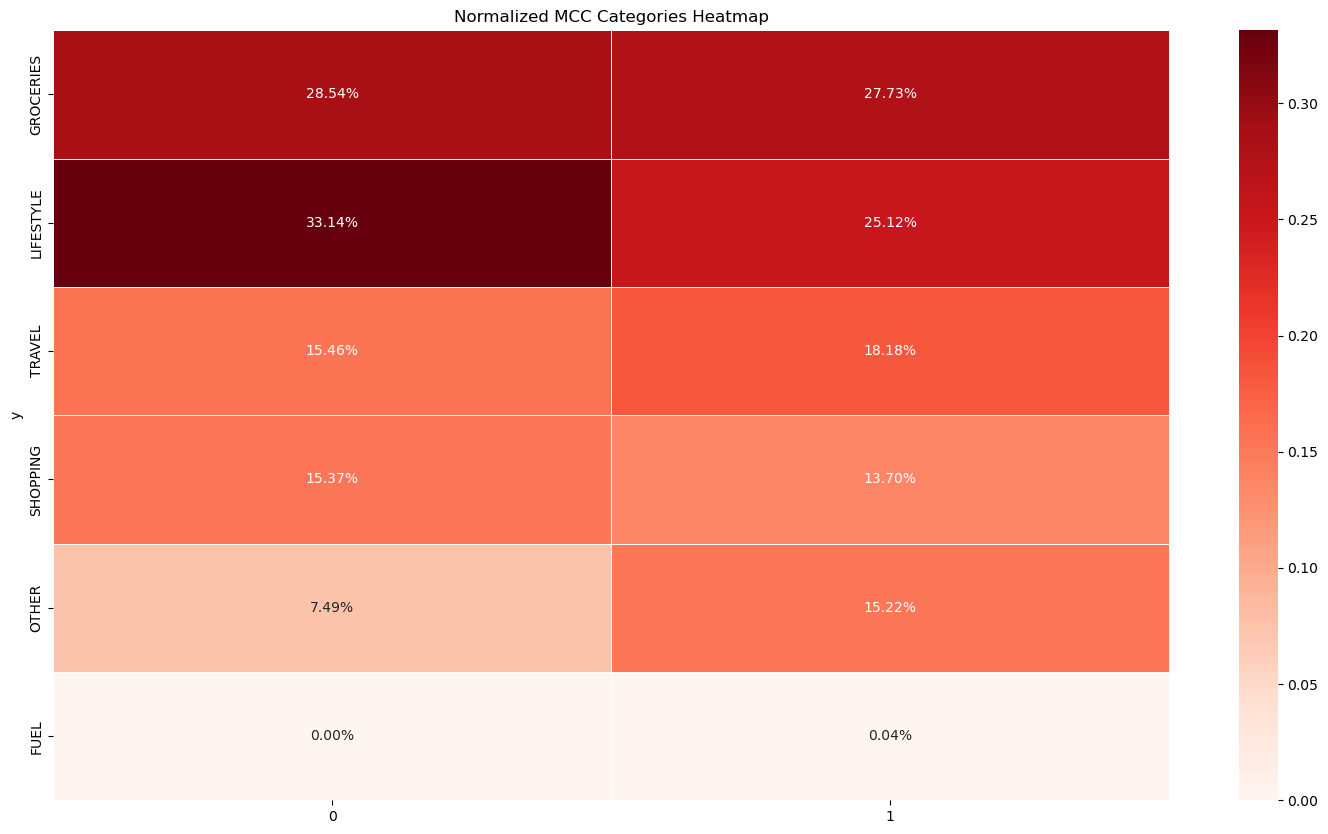

In [90]:
heatmaps(df_clusters, filtered_data, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], topn=20, relative=False, value='frequency', level_detail=True)

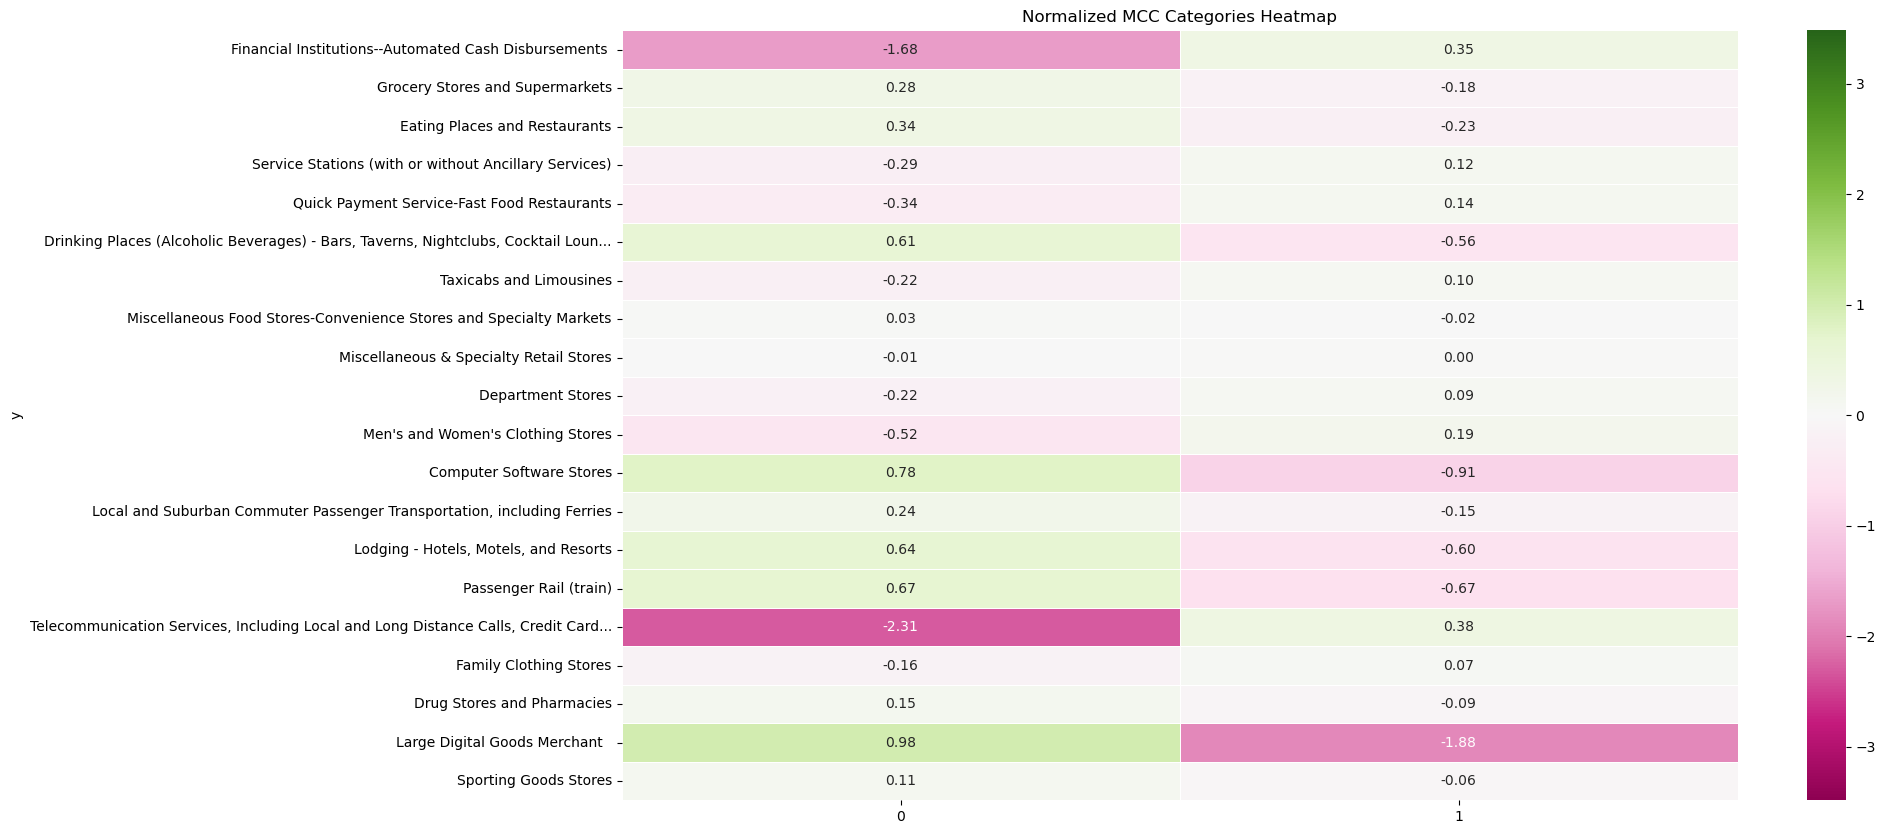

In [91]:
heatmaps(df_clusters, filtered_data, yvalues=['MCC_List'], xvalues=['level_0'], topn=20, relative=True, value='amount', level_detail=True, max_label_len=80)

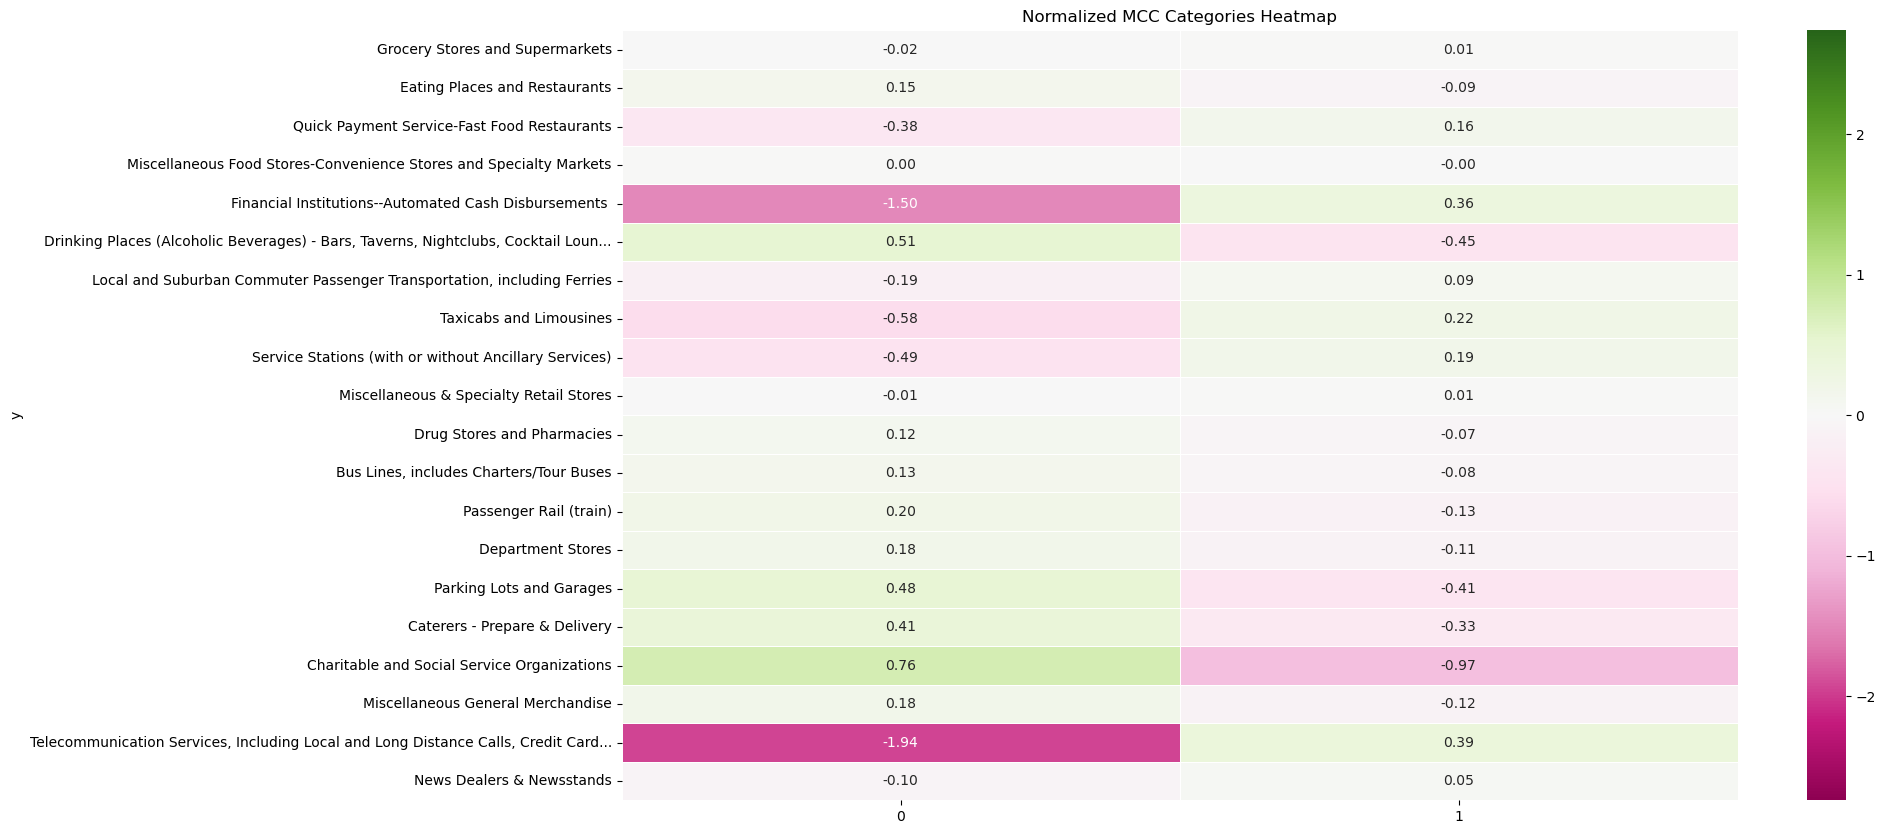

In [92]:
heatmaps(df_clusters, filtered_data, yvalues=['MCC_List'], xvalues=['level_0'], topn=20, relative=True, value='frequency', level_detail=True, max_label_len=80)

In [ ]:
df_imd.columns

Index(['CustomerId', 'Index_of_Multiple_Deprivation_Decile', 'Postcode_Status',
       'LSOA_code', 'LSOA_Name', 'Index_of_Multiple_Deprivation_Rank',
       'Income_Rank', 'Income_Decile', 'Income_Score', 'Employment_Rank',
       'Employment_Decile', 'Employment_Score', 'Education_and_Skills_Rank',
       'Education_and_Skills_Decile', 'Health_and_Disability_Rank',
       'Health_and_Disability_Decile', 'Crime_Rank', 'Crime_Decile',
       'Barriers_to_Housing_and_Services_Rank',
       'Barriers_to_Housing_and_Services_Decile', 'Living_Environment_Rank',
       'Living_Environment_Decile', 'IDACI_Rank', 'IDACI_Decile',
       'IDACI_Score', 'IDAOPI_Rank', 'IDAOPI_Decile', 'IDAOPI_Score', 'age'],
      dtype='object')

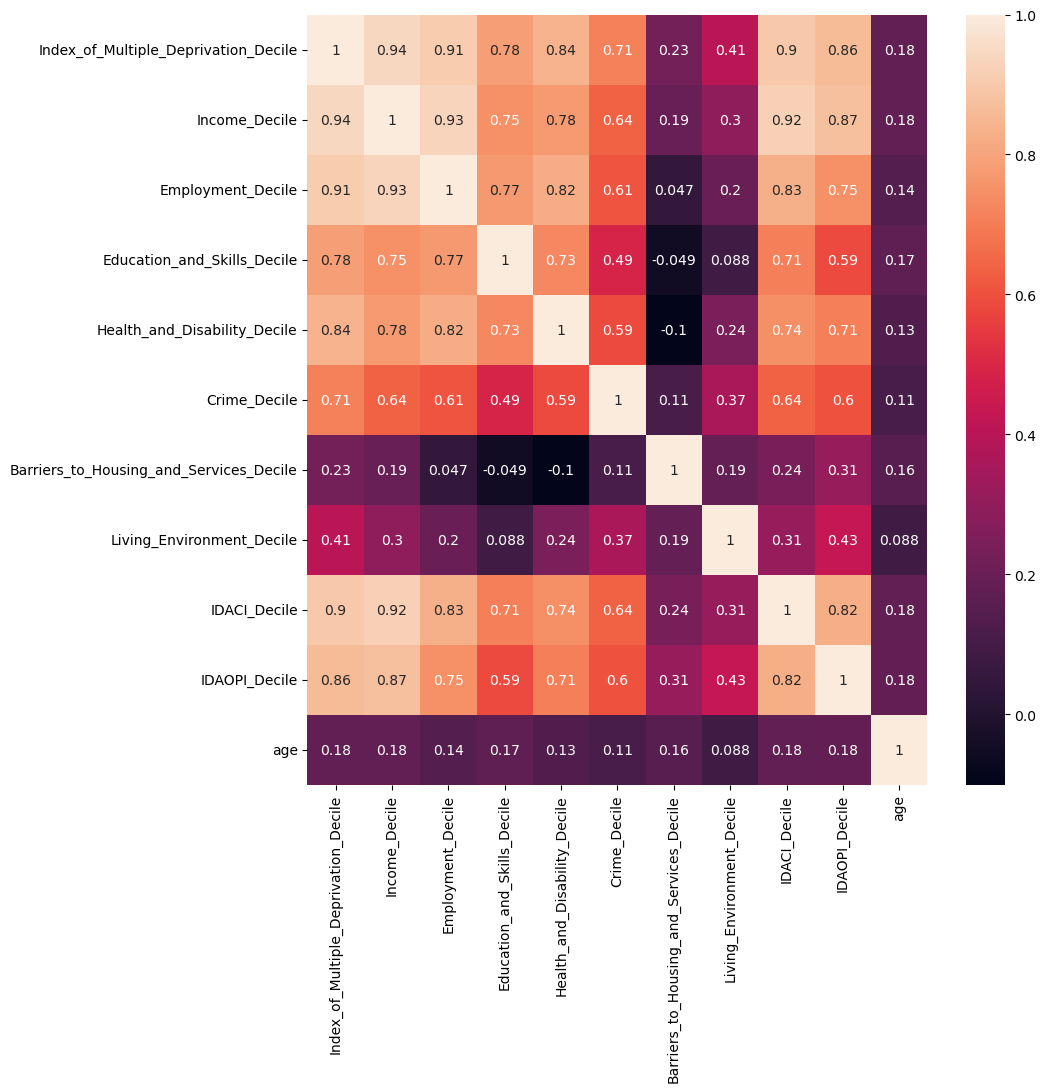

In [117]:
# plot correlation matrix of ['Index_of_Multiple_Deprivation_Decile', 'Income_Decile', 'Employment_Decile', 'Education_Skills_Training_Decile', 'Health_Disability_Decile', 'Crime_Decile', 'Barriers_to_Housing_and_Services_Decile', 'Living_Environment_Decile', 'IDACI_Decile', 'IDAOPI_Decile', 'Age']
plt.figure(figsize=(10,10))
sns.heatmap(df_imd[['Index_of_Multiple_Deprivation_Decile', 'Income_Decile', 'Employment_Decile', 'Education_and_Skills_Decile', 'Health_and_Disability_Decile', 'Crime_Decile', 'Barriers_to_Housing_and_Services_Decile', 'Living_Environment_Decile', 'IDACI_Decile', 'IDAOPI_Decile', 'age']].corr(), annot=True)
# rotate the x-axis labels
# plt.xticks(rotation=45)
plt.show()

In [ ]:
df_clusters['imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Index_of_Multiple_Deprivation_Decile'])
df_clusters['age'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['age'])
# df_clusters['income_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Income_Decile'])
# df_clusters['employ_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Employment_Decile'])
# df_clusters['edu_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Education_and_Skills_Decile'])
# df_clusters['health_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Health_and_Disability_Decile'])
# df_clusters['crime_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Crime_Decile'])
df_clusters['bhs_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Barriers_to_Housing_and_Services_Decile'])
df_clusters['living_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Living_Environment_Decile'])
df_clusters['IDACI_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['IDACI_Decile'])
df_clusters['IDAOPI_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['IDAOPI_Decile'])

IDACI (Income Deprivation Affecting Children Index)

IDAOPI (Income Deprivation Affecting Older People Index)

In [ ]:
df_clusters

node  level_0   imd   age  bhs_imd  \
0    d7742e27-7677-431e-8da4-426e977e958e        0   8.0  23.0      4.0   
1    e1090e22-632f-45e4-a480-b9206b3a573d        0   NaN   NaN      NaN   
2    bae5dffb-f840-4b05-843a-b1a1e50bf98e        0   5.0  32.0      8.0   
3    ba5bf2df-a4ff-44d4-b3c9-1dab98b87580        0  10.0  47.0      3.0   
4    40145ab5-241c-47c5-bb6a-3a05374b28a9        0   4.0   NaN      2.0   
..                                    ...      ...   ...   ...      ...   
364  f601e896-6666-4ff6-a6d0-4748d1412f24        1   4.0  20.0      3.0   
365  f5cb8a1b-f495-4bf5-b261-d3704e2d9324        1   8.0  20.0      5.0   
366  f5bd29b1-42a1-474e-a260-abd9f132c339        1   1.0  25.0      2.0   
367  f582fbee-0081-4b1c-b009-3e45cd4950f6        1   1.0  28.0      1.0   
368  f47e9533-fe63-45ef-a7d8-1c0886dff2d9        1   NaN   NaN      NaN   

     living_imd  IDACI_imd  IDAOPI_imd  
0           3.0        9.0         5.0  
1           NaN        NaN         NaN  
2           3.0        4.0         5.0  
3           8.0        9.0         8.0  
4           5.0        2.0         2.0  
..          ...        ...         ...  
364         6.0        3.0         4.0  
365        10.0        5.0         8.0  
366         1.0        2.0         1.0  
367         4.0        2.0         1.0  
368         NaN        NaN         NaN  

[369 rows x 8 columns]

In [ ]:
df_clusters.isna().sum()

node           0
level_0        0
imd           59
age           71
bhs_imd       59
living_imd    59
IDACI_imd     59
IDAOPI_imd    59
dtype: int64

In [102]:
df_corr = df_clusters.copy()
df_corr.dropna(inplace=True)

In [103]:
df_corr.groupby('level_0')[['imd', 'age', 'bhs_imd', 'living_imd', 'IDACI_imd', 'IDAOPI_imd']].mean()

imd        age   bhs_imd  living_imd  IDACI_imd  IDAOPI_imd
level_0                                                                  
0        6.259259  40.000000  5.518519    4.481481   6.370370    5.481481
1        4.103321  30.158672  4.302583    4.143911   4.077491    3.678967

In [104]:
df_corr.groupby('level_0')['node'].count()

level_0
0     27
1    271
Name: node, dtype: int64

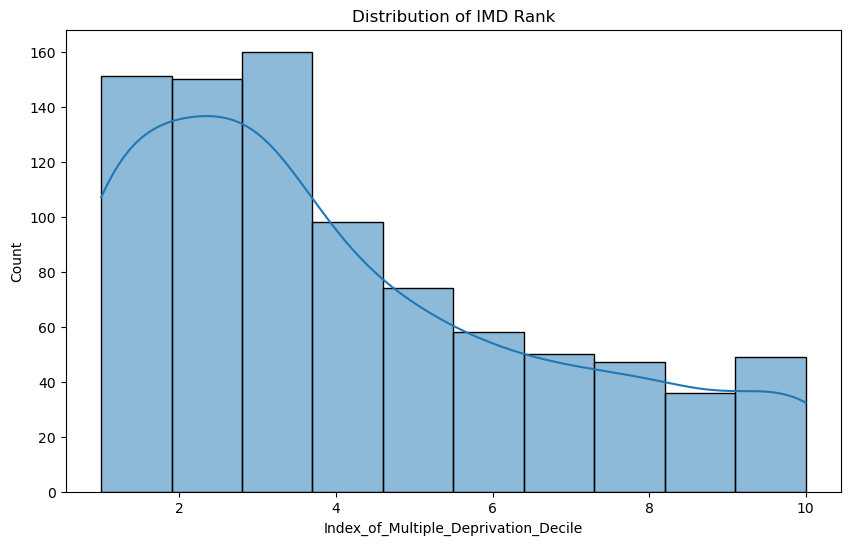

In [110]:
# plot the distribution of imd, age in df_imd
plt.figure(figsize=(10,6))
sns.histplot(df_imd['Index_of_Multiple_Deprivation_Decile'], bins=10, kde=True)
plt.title('Distribution of IMD Rank')
plt.show()

In [108]:
# calculate the chi-square test for each feature to determine the independence of the feature and the cluster(H0: independent, H1: dependent)
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def chi_square_test(df, feature):
    # Create a contingency table
    contingency_table = pd.crosstab(df['level_0'], df[feature])
    # Perform the chi-square test
    stat, p, dof, expected = chi2_contingency(contingency_table)
    # Determine the critical value
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    # Print the results
    print(f'Chi-Square Test for {feature}:')
    print(f'Statistic: {stat:.3f}')
    print(f'p-value: {p:.3f}')
    print(f'Degree of Freedom: {dof}')
    print(f'Critical Value: {critical:.3f}')
    # Determine the significance
    alpha = 1.0 - prob
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print()

for feature in features:
    chi_square_test(df_corr, feature)

Chi-Square Test for imd:
Statistic: 18.740
p-value: 0.027
Degree of Freedom: 9
Critical Value: 16.919
Dependent (reject H0)

Chi-Square Test for age:
Statistic: 101.061
p-value: 0.000
Degree of Freedom: 38
Critical Value: 53.384
Dependent (reject H0)

Chi-Square Test for bhs_imd:
Statistic: 9.168
p-value: 0.422
Degree of Freedom: 9
Critical Value: 16.919
Independent (fail to reject H0)

Chi-Square Test for living_imd:
Statistic: 8.130
p-value: 0.521
Degree of Freedom: 9
Critical Value: 16.919
Independent (fail to reject H0)

Chi-Square Test for IDACI_imd:
Statistic: 19.235
p-value: 0.023
Degree of Freedom: 9
Critical Value: 16.919
Dependent (reject H0)

Chi-Square Test for IDAOPI_imd:
Statistic: 29.387
p-value: 0.001
Degree of Freedom: 9
Critical Value: 16.919
Dependent (reject H0)



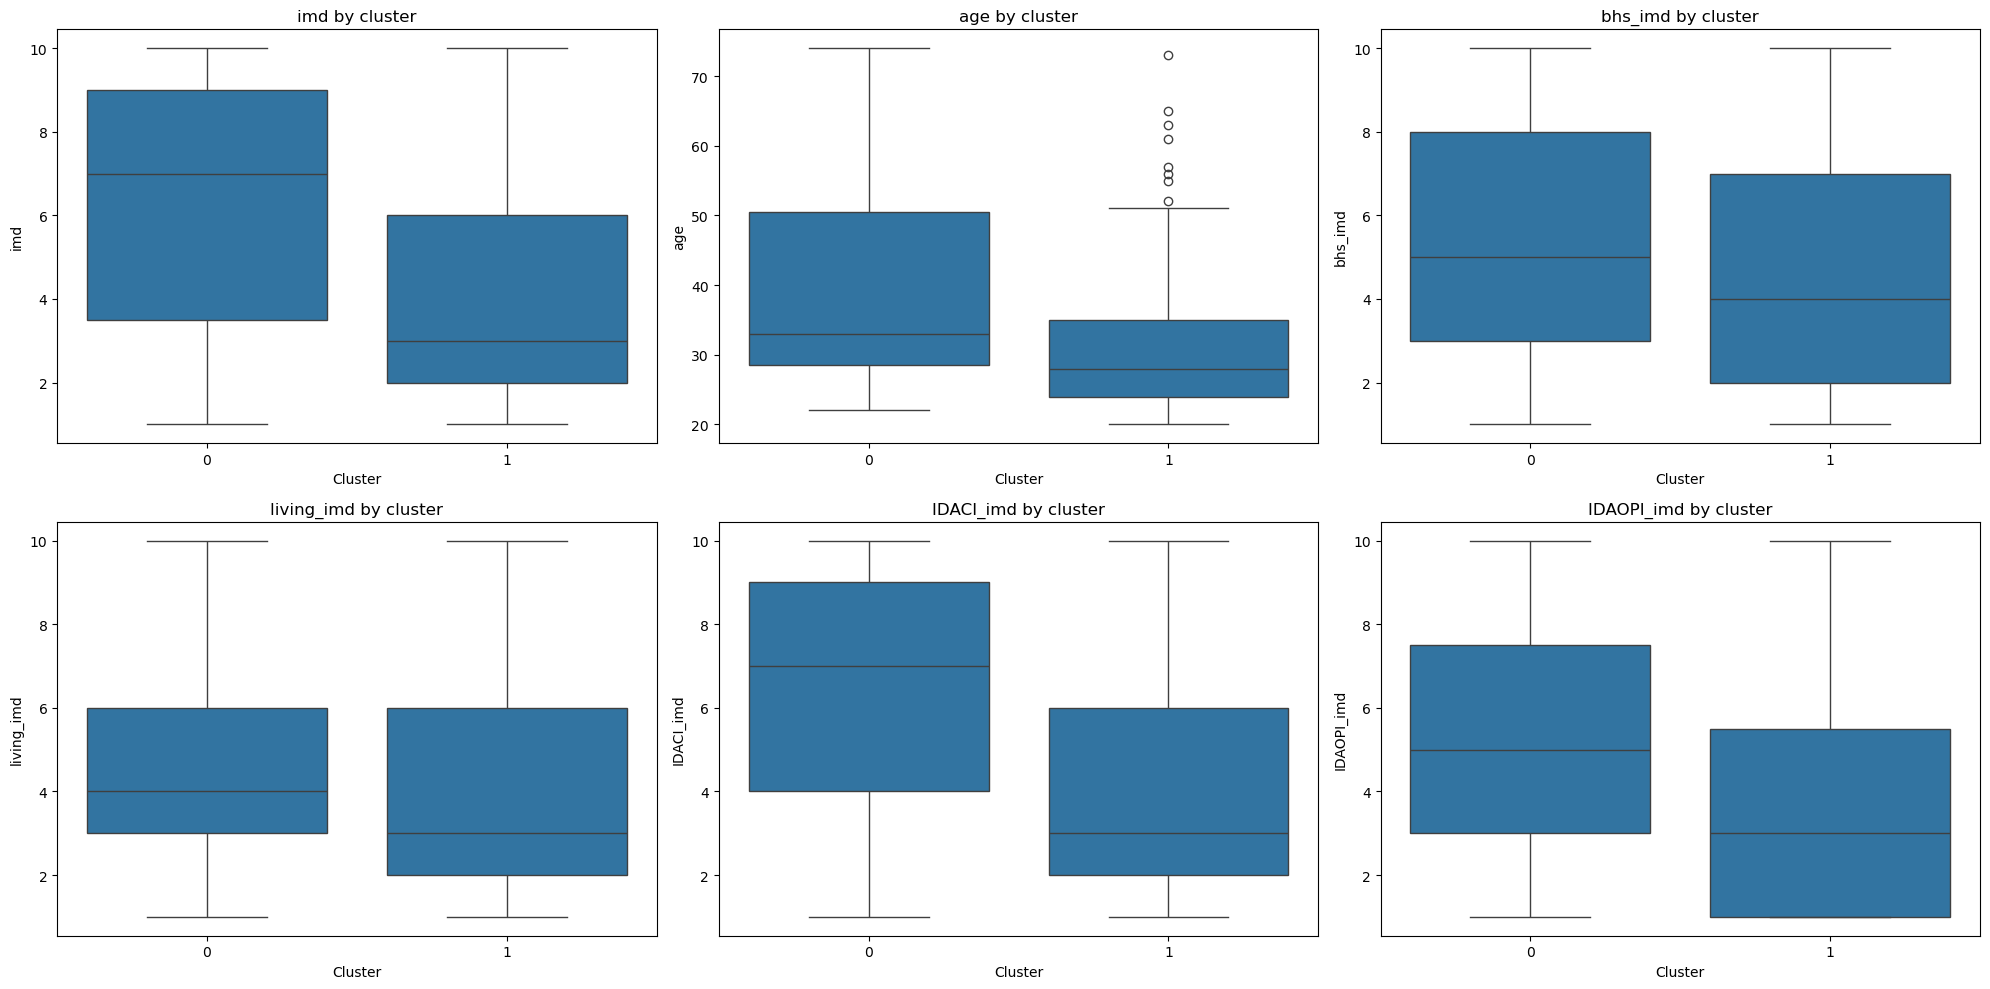

In [106]:
# plot the distribution of each feature for each cluster in a plot of 2x3
features = ['imd', 'age', 'bhs_imd', 'living_imd', 'IDACI_imd', 'IDAOPI_imd']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, feature in enumerate(features):
    sns.boxplot(x='level_0', y=feature, data=df_corr, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{feature} by cluster')
    axes[i//3, i%3].set_xlabel('Cluster')
    axes[i//3, i%3].set_ylabel(feature)
plt.tight_layout()
plt.show()

## customers statistics

df_